In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import itertools
from mphelper import ProcessWrapPool
import biodataplot.genomeview as gv
import biodataplot.utils as bpu
from collections import defaultdict
from biodata.delimited import DelimitedWriter
import pybedtools
from pathlib import Path
import sys

In [4]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [5]:
sys.path.append(str(Path.cwd().parent))
import utils

In [16]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/kl945/EnhancerAtlas/PROcap/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/"
PROJECT_DIR_o2 = "/home/yc2553/projects/HEA/output/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/genomes/human/"

# Pause distance changes in KD cell lines

In [17]:
factors = ["NELFC", "MED14", "BRD4", 
		   "CDK7", "CTCF", "POLR2A",
		   "RAD21", "SMARCA5", "SUPT16H"
		  ]
treatments = ["U", "T"]
reps = ["1", "2"]
ks = ["pl", "mn"]
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]

In [18]:
# NELF-C data: got it from the literature

rep_IDs = {"NELFC_U1": "SRR11024629",
		"NELFC_U2": "SRR11024632",
		"NELFC_T1": "SRR11024631",
		"NELFC_T2": "SRR11024633"
		}

In [19]:
# Other factors

for factor, treatment, rep in itertools.product(factors, treatments, reps):
	if factor != "NELFC":
		rep_IDs[f"{factor}_{treatment}{rep}"] = f"{factor}_{treatment}{rep}"

In [20]:
pause_distance_beds = {}
for rep, sid in rep_IDs.items():
	pause_distance_beds[rep] = [f"{PROJECT_DIR_d}Alignments/{sid}_d{k}.bed.bgz" for k in ks]

In [21]:
prefix = {}
for factor, treatment in itertools.product(factors, treatments):
	if factor == "NELFC":
		prefix[(factor, "U")] = "brm_SRR11024629_and_SRR11024632_erm"
		prefix[(factor, "T")] = "brm_SRR11024631_and_SRR11024633_erm"
	else:
		prefix[(factor, treatment)] = f"brm_{factor}_{treatment}1_and_{factor}_{treatment}2_erm"

In [22]:
# Peak calling at sample level

peak_beds = {}
for factor, treatment in itertools.product(factors, treatments):
	peak_beds[(factor, treatment)] = [f"{PROJECT_DIR_d}Peaks/PINTS/{prefix[(factor, treatment)]}_1_{p}_peaks.bed" for p in ps]

In [23]:
def get_reads_in_defined_regions(rep):
	# Combine pausing distance on forward and reverse strands
	b1 = pybedtools.BedTool(pause_distance_beds[rep][0])
	b2 = pybedtools.BedTool(pause_distance_beds[rep][1])
	chroms = [f"chr{n}" for n in range(1,23)]+["chrX"]
	b_pause = b1.cat(b2, postmerge=False).filter(lambda x: x.chrom in chroms).saveas()
	# Combine divergent and unidirectional elements
	factor, treatment = rep.split("_")[0], rep.split("_")[1][0]
	b1 = pybedtools.BedTool(peak_beds[(factor, treatment)][0])
	b2 = pybedtools.BedTool(peak_beds[(factor, treatment)][1])
	b_es = b1.cat(b2)
	# Focus on reads found in PRO-cap elements
	keep = set([tuple(i.fields) for i in b_pause.intersect(b_es, u=True)])
	# Separate them into distal and proximal
	for d in ds:
		outputfile = f"{PROJECT_DIR_o}temp/{rep}_{d}_pausing_distance.bed.bgz"
		records = [i.fields for i in b_pause.intersect(tss, v=True) if tuple(i.fields) in keep] if d == "distal" else [i.fields for i in b_pause.intersect(tss, u=True) if tuple(i.fields) in keep]
		with DelimitedWriter(outputfile) as dw:
			for record in records:
				dw.write(record)

In [24]:
pwpool = ProcessWrapPool(10)

tss = pybedtools.BedTool(f'{PROJECT_DIR_r}gencode.v37.annotation.TSS.500.bed.bgz')
for rep in rep_IDs:
	pwpool.run(get_reads_in_defined_regions, args=[rep])

In [18]:
len(pwpool.finished_tasks)

In [17]:
pwpool.close()

In [26]:
# Get pause distances for each sample

pwpool = ProcessWrapPool(len(factors))

map_dict = {}
for rep, d in itertools.product(rep_IDs, ds):
	inputfile = f"{PROJECT_DIR_o}temp/{rep}_{d}_pausing_distance.bed.bgz"
	map_dict[(rep,d)] = pwpool.run(utils.get_pause_distances, args=[inputfile])

In [28]:
len(pwpool.finished_tasks)

72

In [29]:
temp = pwpool.get()
pause_distances = {}
for k in map_dict:
	pause_distances[k] = temp[map_dict[k]]

In [30]:
pwpool.close()

In [31]:
colors = ["#bdbdbd", "#525252", "#fb9a99", "#e31a1c"]

In [70]:
def plot_one_distribution(d, factor, ax, plot_xlabel=True, plot_ylabel=True, plot_legend=True):
	cs = itertools.cycle(colors)
	for treatment, rep in itertools.product(treatments, reps):
		cter = pause_distances[(f"{factor}_{treatment}{rep}", d)]
		y = [cter[i] for i in range(100)]
		ttl = sum(y)
		y = np.array(y) / sum(y)
		ax.plot(np.arange(100), y, label=f"{treatment}_{rep}", color=next(cs))
	handles, labels = ax.get_legend_handles_labels()
	new_labels = []
	for l in labels:
		treatment, rep = l.split("_")
		treatment = "- Auxin" if treatment == "U" else "+ Auxin"
		new_labels.append(f"{treatment} (rep {rep})")
	if plot_legend:
		ax.legend(handles, new_labels, title="", fontsize=sfontsize,
				  loc="upper left", bbox_to_anchor=(1.1,1), frameon=False
				 )
	else:
		ax.legend([],[],frameon=False)

	title = factor if factor != "NELFC" else "NELF-C"
	ax.spines[["top", "right"]].set_visible(False)
	ax.set_title(title, fontsize=bfontsize)

	ax.tick_params(labelsize=sfontsize)
	if plot_xlabel:
		ax.set_xlabel("Pause distance", fontsize=bfontsize)
	if plot_ylabel:
		ax.set_ylabel("Frequency", fontsize=bfontsize)
	ax.set_yticks([0, 0.01, 0.02, 0.03])
	ax.set_ylim([-0.005, 0.04])
	ax.yaxis.set_label_coords(-0.6, 0.5)

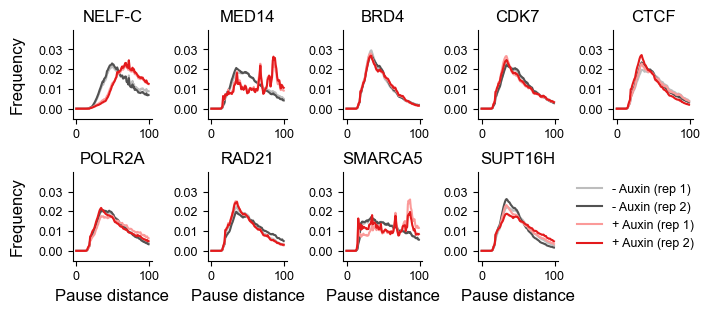

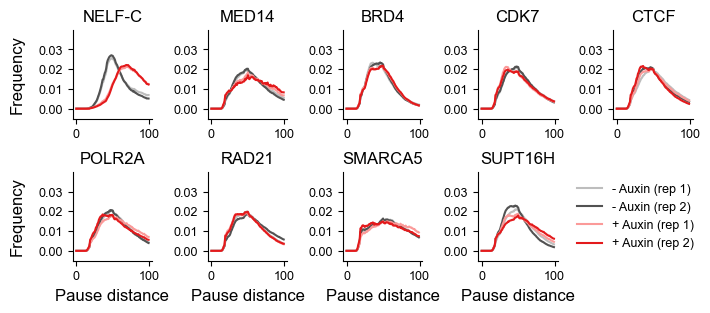

In [71]:
for d in ds:
	fig, ax = plt.subplots(2, 5, figsize=(8,3))
	ax[1,4].axis("off")
	for factor in factors:
		row = factors.index(factor) // 5
		col = factors.index(factor) % 5
		plot_xlabel = True if row == 1 else False
		plot_ylabel = True if col == 0 else False
		plot_legend = True if row == 1 and col == 3 else False
		plot_one_distribution(d, factor, ax[row, col], plot_xlabel, plot_ylabel, plot_legend)
	fig.subplots_adjust(wspace=0.7, hspace=0.6)
	figN = "a" if d == "distal" else "b"
	plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig8{figN}.pdf", bbox_inches="tight", transparent=True)

# Example browser shots

In [ ]:
# Show the broswer shot of one representative region
# 5' and 3' for NELF-C and MED14 before and after degradation

In [49]:
data = defaultdict(dict)
formatters = defaultdict(dict)
texts = {}
candidates = ["NELFC"]
for s in candidates:
	data[s][f"5'_-Auxin_{s}"] = [f"{PROJECT_DIR_d}Alignments/{prefix[(s, 'U')]}_5{k}.bw" for k in ks]
	data[s][f"5'_+Auxin_{s}"] = [f"{PROJECT_DIR_d}Alignments/{prefix[(s, 'T')]}_5{k}.bw" for k in ks]
	data[s][f"3'_-Auxin_{s}"] = [f"{PROJECT_DIR_d}Alignments/{prefix[(s, 'U')]}_3{k}.bw" for k in ks]
	data[s][f"3'_+Auxin_{s}"] = [f"{PROJECT_DIR_d}Alignments/{prefix[(s, 'T')]}_3{k}.bw" for k in ks]

	for k in data[s]:
		formatters[s][k] = {"yscale":"asym_pos_neg", "plot_kw":{"width":3},
							"pcolor":"red", "ncolor":"blue"
						   }

In [64]:
def browser_shot(chrom, start, end, data, formatters, title, outputfile, size=700):
	region = f"{chrom}:{start}-{end}"
	region = utils.expand_genomic_pos(region, size)
	fig = gv.plot_genome_view(region,
								data,
								formatters
								)

	bpu.plt_change_figure_properties(
									fig,
									**{"fig_prop": {"size_inches":[6.5, 3.5]},
									"fig_suptitle": title,
									"fig_suptitle_kwargs": {"fontsize":bfontsize, "y":0.96},
									"locator_prop": {"nbins":2, "axis":"x"},
									"xticklabels_prop": {"fontsize":sfontsize},
									"yticklabels_prop": {"fontsize":sfontsize},
									"xlabel_prop": {"fontsize":bfontsize, "text":""},
									"ylabel_prop": {"fontsize":bfontsize, "text":""}
									},
									title_prop = {"text": ""}
								)
	
	ax = fig.add_axes([0,0,1,1])
	ax.axis('off')
	trans = ax.get_yaxis_transform()
	
	for i in range(len(data)):
		if i == len(data)-1:
			# xlabel
			bpu.plt_change_figure_properties(
				fig,
				ax_targets=[i],
				xlabel_prop={"text":chrom}
				)
			fig.axes[i].xaxis.set_label_coords(0.5, -0.8)
			
		# yticklabels
		color = "#969696" if i % 2 == 0 else "#fb8072"
		k = list(data)[i]
		text = f"{k.split('_')[0]} ({k.split('_')[1]})"
		bpu.plt_change_figure_properties(fig,
										ax_targets=[i],
										ylabel_prop={"color":color, "text":text, "va": "center", "ha": "center"}
										)
		fig.axes[i].yaxis.set_label_coords(-0.2, 0.5)
	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

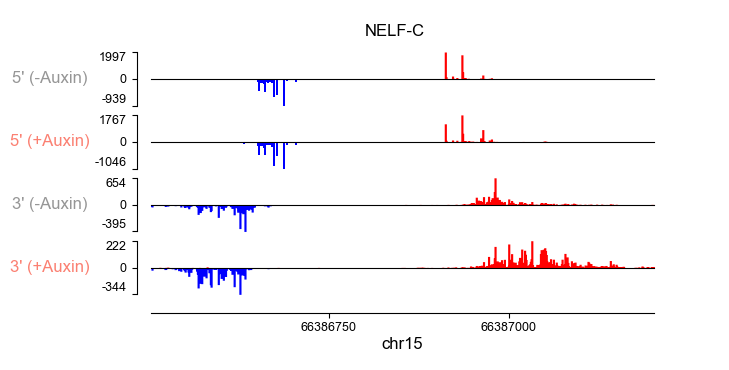

In [65]:
s = "NELFC"
d = "proximal"
e = "chr15_66386611_66387094"
chrom, start, end = e.split("_")
outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig8c.pdf"
browser_shot(chrom, start, end, data[s], formatters[s], "NELF-C", outputfile)